In [1]:
import sys
import numpy as np
import time
import os
import sys
import random
import gc
import scipy.ndimage as ndimage
from skimage.transform import resize
import matplotlib.pyplot as plt

from deepmass import map_functions as mf
from deepmass import lens_data as ld
from deepmass import wiener
from deepmass import cnn_keras as cnn

In [40]:
map_size = 128
n_test = int(500)
n_epoch = 15
batch_size = 64
learning_rate = 1e-4

foreground_amplitude_rescale = 253775.
T_mean_cmb = 2.726*1e6

In [41]:
noisy_array = np.load('../foregrounds/foreground_256_041219.npy', mmap_mode='r+')
noisy_array = noisy_array[:12000,:map_size,:map_size].astype(np.float32)
gc.collect()

48

In [42]:
clean_array = np.load('../foregrounds/map_256_041219.npy', mmap_mode='r+')
clean_array = clean_array[:12000,:map_size,:map_size].astype(np.float32)
gc.collect()

28

In [43]:
print(np.std(ndimage.gaussian_filter(noisy_array[0,:,:,0], 1))*foreground_amplitude_rescale)
print(np.std(clean_array))

11608.764431159943
9386.615


In [44]:
for i in range(noisy_array.shape[0]):
    if i%(int(noisy_array.shape[0]/100))==0: print(i, flush=True)
    noisy_array[i,:,:,0] = ndimage.gaussian_filter(noisy_array[i,:,:,0], 1)*foreground_amplitude_rescale
gc.collect()

0
120
240
360
480
600
720
840
960
1080
1200
1320
1440
1560
1680
1800
1920
2040
2160
2280
2400
2520
2640
2760
2880
3000
3120
3240
3360
3480
3600
3720
3840
3960
4080
4200
4320
4440
4560
4680
4800
4920
5040
5160
5280
5400
5520
5640
5760
5880
6000
6120
6240
6360
6480
6600
6720
6840
6960
7080
7200
7320
7440
7560
7680
7800
7920
8040
8160
8280
8400
8520
8640
8760
8880
9000
9120
9240
9360
9480
9600
9720
9840
9960
10080
10200
10320
10440
10560
10680
10800
10920
11040
11160
11280
11400
11520
11640
11760
11880


40

In [45]:
noisy_array = np.add(noisy_array,clean_array)
gc.collect()
noisy_array = (noisy_array-T_mean_cmb)/3e5 +0.5
gc.collect()
clean_array = (clean_array-T_mean_cmb)/3e5 +0.5
gc.collect()

0

In [46]:
test_array_noisy = noisy_array[:n_test]
test_array_clean = clean_array[:n_test]
gc.collect()

20

In [47]:
noisy_array = noisy_array[n_test:]
clean_array = clean_array[n_test:]
gc.collect()

20

(<matplotlib.image.AxesImage at 0x7fc0ad2aba90>,
 <matplotlib.colorbar.Colorbar at 0x7fc0acfe04a8>)

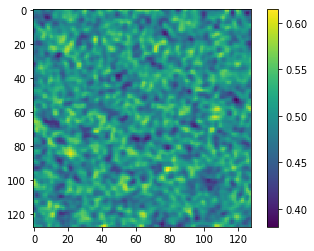

In [48]:
plt.imshow(clean_array[0,:,:,0]), plt.colorbar()

(<matplotlib.image.AxesImage at 0x7fc0ad15fc50>,
 <matplotlib.colorbar.Colorbar at 0x7fc0ad396470>)

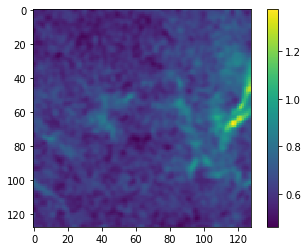

In [49]:
plt.imshow(noisy_array[0,:,:,0]), plt.colorbar()

In [50]:
train_gen = cnn.BatchGenerator(noisy_array, clean_array, gen_batch_size=batch_size)
test_gen = cnn.BatchGenerator(test_array_noisy, test_array_clean, gen_batch_size=batch_size)

cnn_instance = cnn.UnetlikeBaseline(map_size=map_size, learning_rate=learning_rate)
cnn_model = cnn_instance.model()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 128, 128, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 128, 128, 16) 64          conv2d_10[0][0]                  
__________________________________________________________________________________________________
average_pooling2d_4 (AveragePoo (None, 64, 64, 16)   0           batch_normalization_9[0][0]      
____________________________________________________________________________________________

In [51]:
history = cnn_model.fit_generator(generator=train_gen,
                         epochs=n_epoch,
                         steps_per_epoch=np.ceil(noisy_array.shape[0] / int(batch_size)),
                         validation_data=test_gen,
                         validation_steps=np.ceil(test_array_noisy.shape[0] / int(batch_size)))

gc.collect()

Epoch 1/15
180/180 [==============================] - 8s 35ms/step - loss: 0.0095 - val_loss: 0.0011
Epoch 2/15
180/180 [==============================] - 6s 34ms/step - loss: 8.9073e-04 - val_loss: 7.5842e-04
Epoch 3/15
180/180 [==============================] - 6s 34ms/step - loss: 5.7338e-04 - val_loss: 5.9266e-04
Epoch 4/15
180/180 [==============================] - 6s 33ms/step - loss: 4.5247e-04 - val_loss: 4.2592e-04
Epoch 5/15
180/180 [==============================] - 6s 33ms/step - loss: 3.9386e-04 - val_loss: 3.8510e-04
Epoch 6/15
180/180 [==============================] - 6s 33ms/step - loss: 3.6106e-04 - val_loss: 3.6310e-04
Epoch 7/15
180/180 [==============================] - 6s 34ms/step - loss: 3.3985e-04 - val_loss: 3.3722e-04
Epoch 8/15
180/180 [==============================] - 6s 34ms/step - loss: 3.2389e-04 - val_loss: 3.1589e-04
Epoch 9/15
180/180 [==============================] - 6s 34ms/step - loss: 3.1280e-04 - val_loss: 2.9987e-04
Epoch 10/15
180/180 [======

22024

In [52]:
test_output = cnn_model.predict(test_array_noisy[:50])

(<matplotlib.image.AxesImage at 0x7fbfd4380dd8>,
 <matplotlib.colorbar.Colorbar at 0x7fbfd440ae48>)

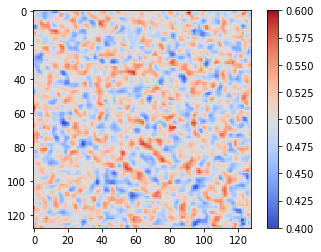

In [53]:
plt.imshow((test_output[0,:,:,0]), cmap='coolwarm', clim=(0.4,0.6)), plt.colorbar()

(<matplotlib.image.AxesImage at 0x7fbfd44c22e8>,
 <matplotlib.colorbar.Colorbar at 0x7fbfd4579b38>)

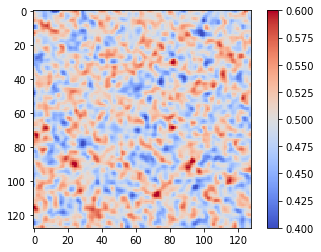

In [54]:
plt.imshow((test_array_clean[0,:,:,0]), cmap='coolwarm', clim=(0.4,0.6)), plt.colorbar()

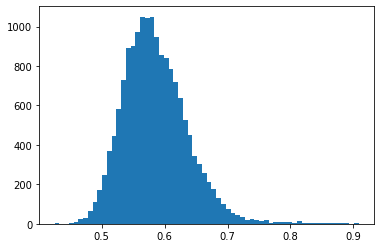

In [55]:
_ = plt.hist(test_array_noisy[0,:,:,0].flatten(), bins=64)

(<matplotlib.image.AxesImage at 0x7fc0ac8e9b38>,
 <matplotlib.colorbar.Colorbar at 0x7fc0ac8a8278>)

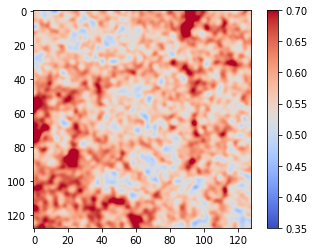

In [59]:
plt.imshow((test_array_noisy[0,:,:,0]), cmap='coolwarm', clim=(0.35,0.7), interpolation='spline16'), plt.colorbar()

(<matplotlib.image.AxesImage at 0x7fbfd4383b00>,
 <matplotlib.colorbar.Colorbar at 0x7fbfd44e74e0>)

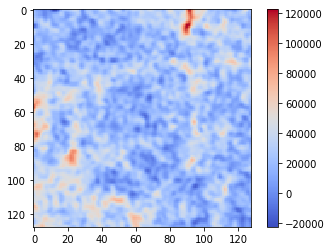

In [57]:
plt.imshow((test_array_noisy[0,:,:,0]-0.5)*3e5, cmap='coolwarm'), plt.colorbar()

(<matplotlib.image.AxesImage at 0x7fbfd43e4ba8>,
 <matplotlib.colorbar.Colorbar at 0x7fbfd438ce48>)

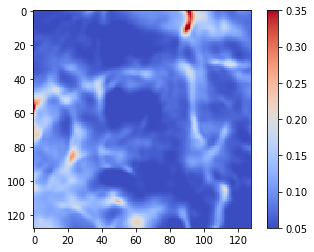

In [58]:
plt.imshow((test_array_noisy[0,:,:,0]-test_array_clean[0,:,:,0]), cmap='coolwarm', clim=(0.05,0.35)), plt.colorbar()